In [12]:
# ===============================
# CG-CNN FOLLOWING THE EXACT DESCRIPTION
# Contextual groups via spatial neighborhoods in feature maps
# ===============================

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report
import random

# ===============================
# CONFIGURATION (Following Description)
# ===============================
IMG_DIR = "/content/drive/MyDrive/CGCNN_research/part_1"
MODEL_SAVE_PATH = "/content/drive/MyDrive/CGCNN_research/cgcnn_contextual.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters - ADJUSTED FOR BETTER LEARNING
WINDOW_SIZE = 5          # 5x5 windows (more context than 3x3)
G_RADIUS = 2             # ±2 pixels around seed (creates 5x5 = 25 windows per group)
N_IMAGES_PER_TASK = 15   # More images per task (was 5)
N_GROUPS = 50            # C=50 contextual groups (as specified)
WINDOWS_PER_GROUP = (2*2+1)**2  # 25 windows around each seed (5x5 grid in ±2 region)
N_TASKS = 1500           # More tasks for better convergence (was 200)
REFINER_DIM = 256        # Q' dimension

print(f"Device: {DEVICE}")
print(f"Window size: {WINDOW_SIZE}x{WINDOW_SIZE} (9 positions)")
print(f"Context radius: ±{G_RADIUS} (creates {(2*G_RADIUS+1)**2} positions per seed)")

Mounted at /content/drive
Device: cuda
Window size: 5x5 (9 positions)
Context radius: ±2 (creates 25 positions per seed)


In [13]:
# ===============================
# 1. DILATED RESNET BACKBONE
# ===============================
class DilatedResNetBackbone(nn.Module):
    """
    Modified ResNet50 with dilation to maintain spatial resolution.
    Output P: [B, 1024, 28, 28] - dense spatial resolution for contextual sampling
    Output Q: [B, 2048, 28, 28] - next block's features (baseline comparison)
    """
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Modify layer3 for dilation (keeps resolution at 28x28)
        layer3 = resnet.layer3
        if layer3[0].downsample is not None:
            layer3[0].downsample[0].stride = (1, 1)
        for block in layer3:
            if block.conv2.kernel_size == (3, 3):
                block.conv2.stride = (1, 1)
                block.conv2.dilation = (2, 2)
                block.conv2.padding = (2, 2)

        # P: intermediate features (layer3 output)
        self.to_P = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3
        )

        # Q: next block features (layer4 output) - for comparison
        self.to_Q = resnet.layer4

        # Freeze everything
        for param in self.parameters():
            param.requires_grad = False
        self.eval()

    def forward(self, x):
        """Returns both P and Q for later comparison"""
        with torch.no_grad():
            P = self.to_P(x)      # [B, 1024, 28, 28]
            Q = self.to_Q(P)      # [B, 2048, 28, 28]
        return P, Q

In [14]:
# ===============================
# 2. CG-CNN REFINER (Learns Q')
# ===============================
class CGCNNRefiner(nn.Module):
    """
    Learns Q' from P using contextual guidance.
    Input: P [B, 1024, H, W]
    Output: Q' [B, REFINER_DIM, H, W]
    """
    def __init__(self, in_dim=1024, refiner_dim=256):
        super().__init__()

        self.refiner = nn.Sequential(
            nn.Conv2d(in_dim, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, refiner_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(refiner_dim),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(refiner_dim, refiner_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(refiner_dim),
            nn.ReLU(inplace=True)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, P):
        """P -> Q'"""
        return self.refiner(P)

    def get_global_features(self, P):
        """Extract image-level features"""
        Q_prime = self.refiner(P)
        return F.adaptive_avg_pool2d(Q_prime, (1, 1)).flatten(1)

In [15]:
# ===============================
# 3. CONTEXTUAL GROUP GENERATOR
# (Following Original CGCNN Logic)
# ===============================
class ContextualGroupGenerator:
    """
    Creates contextual groups following the EXACT description:

    1. Sample C=50 random seed positions in feature map P
    2. For each seed at position (cy, cx):
       - Extract windows at positions within ±g radius
       - Each position gives a window_size × window_size feature patch
       - All patches around one seed = one contextual group
    3. This creates C groups, each with multiple spatially-related windows
    """
    def __init__(self, window_size=5, g_radius=2):
        self.window_size = window_size  # Size of each window (3x3)
        self.g = g_radius                # Radius around seed (±1)

    def extract_window(self, feature_map, cy, cx):
        """
        Extract window_size × window_size window centered at (cy, cx).
        feature_map: [C, H, W]
        Returns: [C, window_size, window_size]
        """
        C, H, W = feature_map.shape
        half_w = self.window_size // 2

        # Bounds checking
        y_start = max(0, cy - half_w)
        y_end = min(H, cy + half_w + 1)
        x_start = max(0, cx - half_w)
        x_end = min(W, cx + half_w + 1)

        window = feature_map[:, y_start:y_end, x_start:x_end]

        # Pad if necessary to maintain window_size
        if window.shape[1] != self.window_size or window.shape[2] != self.window_size:
            window = F.interpolate(
                window.unsqueeze(0),
                size=(self.window_size, self.window_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

        return window

    def augment_window(self, window):
        """
        Apply augmentations to feature windows.
        This creates contextual variation as in original CG-CNN.

        For feature maps, we use:
        - Channel dropout (simulates different activations)
        - Gaussian noise (small perturbations)
        - Spatial flips (geometric invariance)
        - Intensity scaling (analogous to color jitter)
        """
        aug_window = window.clone()

        # 1. Random channel dropout (20% chance)
        if random.random() < 0.2:
            # Randomly zero out 10% of channels
            mask = torch.rand(aug_window.shape[0], 1, 1, device=aug_window.device) > 0.1
            aug_window = aug_window * mask

        # 2. Gaussian noise (30% chance)
        if random.random() < 0.3:
            noise = torch.randn_like(aug_window) * 0.02
            aug_window = aug_window + noise

        # 3. Random horizontal flip (50% chance)
        if random.random() < 0.5:
            aug_window = torch.flip(aug_window, dims=[-1])

        # 4. Random vertical flip (50% chance)
        if random.random() < 0.5:
            aug_window = torch.flip(aug_window, dims=[-2])

        # 5. Intensity scaling (30% chance, analogous to brightness/contrast)
        if random.random() < 0.3:
            scale = random.uniform(0.9, 1.1)
            aug_window = aug_window * scale

        return aug_window

    def create_contextual_group(self, feature_map, seed_cy, seed_cx):
        """
        Create one contextual group by sampling windows around a seed.

        Combines TWO sources of contextual variation (as in original CG-CNN):
        1. Spatial: Windows at positions within ±g of seed
        2. Appearance: Augmentations of each window

        Returns: list of windows (each is [C, window_size, window_size])
        """
        group_windows = []

        # Sample windows in ±g neighborhood around seed
        for dy in range(-self.g, self.g + 1):
            for dx in range(-self.g, self.g + 1):
                cy = seed_cy + dy
                cx = seed_cx + dx

                window = self.extract_window(feature_map, cy, cx)

                # Apply augmentation to create variation
                # (Original CG-CNN applied color jitter, translations, etc.)
                aug_window = self.augment_window(window)

                group_windows.append(aug_window)

        return group_windows

    def create_task(self, backbone, dataset, n_images=5, n_groups=50):
        """
        Create one CG-CNN task following the description:

        1. Select n_images images (5 as specified)
        2. Extract feature maps P for each image
        3. Sample C=50 random seed positions across all feature maps
        4. For each seed, create contextual group (windows in ±g radius)
        5. Return all windows with group labels

        Returns:
            X: [total_windows, C, window_size, window_size]
            y: [total_windows] group labels (0 to n_groups-1)
        """
        device = next(backbone.parameters()).device

        # Step 1 & 2: Get feature maps from n_images images
        image_indices = random.sample(range(len(dataset)), min(n_images, len(dataset)))
        feature_maps = []

        for idx in image_indices:
            img = dataset[idx].unsqueeze(0).to(device)
            P, _ = backbone(img)
            feature_maps.append(P.squeeze(0))  # [1024, 28, 28]

        # Step 3: Sample C=50 random seed positions
        all_windows = []
        all_labels = []

        for group_id in range(n_groups):
            # Randomly select which image's feature map to use for this seed
            feat_map = random.choice(feature_maps)
            C, H, W = feat_map.shape

            # Random seed position (with margins for ±g and window extraction)
            margin = self.g + self.window_size // 2 + 1
            seed_cy = random.randint(margin, H - margin - 1)
            seed_cx = random.randint(margin, W - margin - 1)

            # Step 4: Create contextual group around this seed
            group_windows = self.create_contextual_group(feat_map, seed_cy, seed_cx)

            # Add to dataset
            for window in group_windows:
                all_windows.append(window)
                all_labels.append(group_id)

        X = torch.stack(all_windows)
        y = torch.tensor(all_labels, dtype=torch.long)

        return X, y

In [16]:
# ===============================
# 4. DISCRIMINATOR
# ===============================
class Discriminator(nn.Module):
    """Classifies which contextual group a window belongs to"""
    def __init__(self, in_dim, n_classes, window_size=5):
        super().__init__()
        flat_dim = in_dim * window_size * window_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [17]:
# ===============================
# 5. CG-CNN TRAINING SYSTEM
# ===============================
class CGCNNTrainer:
    """
    Implements the exact training procedure from the description.
    """
    def __init__(self, backbone, refiner_dim=256, window_size=5,
                 g_radius=2, n_groups=50, device='cuda'):
        self.device = device
        self.n_groups = n_groups

        self.backbone = backbone.to(device)
        self.refiner = CGCNNRefiner(in_dim=1024, refiner_dim=refiner_dim).to(device)

        self.task_gen = ContextualGroupGenerator(window_size, g_radius)

        self.refiner_optimizer = torch.optim.Adam(
            self.refiner.parameters(),
            lr=1e-5,
            weight_decay=1e-5
        )

        self.task_accuracies = []
        self.losses_e = []
        self.losses_m = []

    def train_on_task(self, dataset, n_images=5, em_iterations=20):
        """
        Train on one task (one EM iteration as described).

        Process:
        1. Select 5 images, extract their P feature maps
        2. Sample C=50 contextual groups from these feature maps
        3. E-step: Train discriminator (refiner frozen)
        4. M-step: Train refiner (discriminator frozen)
        5. Repeat E-M alternation
        """
        # Generate task: C=50 groups from 5 images
        X_task, y_task = self.task_gen.create_task(
            self.backbone,
            dataset,
            n_images=n_images,
            n_groups=self.n_groups
        )
        X_task = X_task.to(self.device)
        y_task = y_task.to(self.device)

        # Create new discriminator for this task
        discriminator = Discriminator(
            in_dim=REFINER_DIM,
            n_classes=self.n_groups,
            window_size=WINDOW_SIZE
        ).to(self.device)
        disc_optimizer = torch.optim.Adam(
            discriminator.parameters(),
            lr=1e-3,
            weight_decay=1e-5
        )

        criterion = nn.CrossEntropyLoss()

        # E-M alternation
        for _ in range(em_iterations):
            # ========== E-STEP ==========
            self.refiner.eval()
            discriminator.train()

            with torch.no_grad():
                Q_prime_windows = self.refiner(X_task)

            disc_optimizer.zero_grad()
            logits = discriminator(Q_prime_windows)
            loss_e = criterion(logits, y_task)
            loss_e.backward()
            disc_optimizer.step()

            # ========== M-STEP ==========
            self.refiner.train()
            discriminator.eval()

            self.refiner_optimizer.zero_grad()
            Q_prime_windows = self.refiner(X_task)
            logits = discriminator(Q_prime_windows)
            loss_m = criterion(logits, y_task)
            loss_m.backward()
            self.refiner_optimizer.step()

        # Compute accuracy
        self.refiner.eval()
        discriminator.eval()
        with torch.no_grad():
            Q_prime_windows = self.refiner(X_task)
            logits = discriminator(Q_prime_windows)
            pred = logits.argmax(dim=1)
            acc = (pred == y_task).float().mean().item()

        self.task_accuracies.append(acc)
        self.losses_e.append(loss_e.item())
        self.losses_m.append(loss_m.item())

        return loss_e.item(), loss_m.item(), acc

    def train(self, dataset, n_tasks=200, n_images_per_task=5, em_iterations=20):
        """Main training loop"""
        print("="*80)
        print("CG-CNN TRAINING (Following Exact Description)")
        print("="*80)
        print(f"Window size:         {WINDOW_SIZE}x{WINDOW_SIZE}")
        print(f"Context radius:      ±{G_RADIUS}")
        print(f"Images per task:     {n_images_per_task}")
        print(f"Groups per task:     {self.n_groups}")
        print(f"Windows per group:   {(2*G_RADIUS+1)**2}")
        print(f"Total tasks:         {n_tasks}")
        print(f"Refiner output dim:  {REFINER_DIM} (this is Q')")
        print("="*80 + "\n")

        for task_num in range(n_tasks):
            loss_e, loss_m, acc = self.train_on_task(
                dataset,
                n_images=n_images_per_task,
                em_iterations=em_iterations
            )
            if task_num % 50 == 0:  # Show visualization every 50 tasks
                visualize_contextual_group(dataset, self, group_idx=0)
            if (task_num + 1) % 20 == 0:
                recent_acc = np.mean(self.task_accuracies[-20:])
                recent_loss_e = np.mean(self.losses_e[-20:])
                recent_loss_m = np.mean(self.losses_m[-20:])

                print(f"Task {task_num+1:3d}/{n_tasks} | "
                      f"E-Loss: {recent_loss_e:.4f} | "
                      f"M-Loss: {recent_loss_m:.4f} | "
                      f"Acc: {acc*100:.1f}% | "
                      f"Avg(20): {recent_acc*100:.1f}%")

        final_avg = np.mean(self.task_accuracies[-50:])
        print("\n" + "="*80)
        print(f"TRAINING COMPLETE!")
        print(f"Final avg accuracy: {final_avg*100:.2f}%")
        print(f"Q' learned from {n_tasks} tasks using contextual guidance")
        print("="*80)

    def save_model(self, path):
        torch.save({
            'refiner': self.refiner.state_dict(),
            'config': {
                'window_size': WINDOW_SIZE,
                'g_radius': G_RADIUS,
                'refiner_dim': REFINER_DIM,
                'n_groups': N_GROUPS,
            },
            'task_accuracies': self.task_accuracies,
            'losses_e': self.losses_e,
            'losses_m': self.losses_m,
        }, path)
        print(f"\n✅ Q' (refiner) saved to {path}")

In [18]:
# ===============================
# 6. DATASETS
# ===============================
class ISICUnlabeledDataset(Dataset):
    def __init__(self, img_dir):
        self.paths = [
            os.path.join(img_dir, f)
            for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

class ISICLabeledDataset(Dataset):
    def __init__(self, csv_path, img_dir):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Simple binary mapping: benign=0, malignant=1
        self.label_map = {
            "benign": 0,
            "malignant": 1
        }

        # Map diagnosis_1 to labels
        self.df['label'] = self.df['diagnosis_1'].str.lower().str.strip().map(self.label_map)

        # Check for any unmapped values
        unmapped = self.df[self.df['label'].isna()]
        if len(unmapped) > 0:
            print(f"Warning: Found {len(unmapped)} rows with unmapped diagnosis values:")
            print(unmapped['diagnosis_1'].value_counts())
            print("These will be dropped from the dataset.")
            self.df = self.df.dropna(subset=['label'])

        self.df['label'] = self.df['label'].astype(int)

        # Print class distribution
        print(f"Class distribution:")
        print(f"  Benign:    {(self.df['label'] == 0).sum()} samples")
        print(f"  Malignant: {(self.df['label'] == 1).sum()} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Handle different possible column names for image ID
        if 'isic_id' in row:
            img_id = row['isic_id']
        elif 'image_id' in row:
            img_id = row['image_id']
        else:
            img_id = row.iloc[0]  # Use first column as fallback

        # Try different file extensions
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.png")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.jpeg")

        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {img_path}")

        return self.transform(img), int(row['label'])

In [19]:
# ===============================
# 7. EVALUATION: Q vs Q'
# ===============================
def compare_Q_vs_Qprime(backbone, refiner_path, csv_path, img_dir, device):
    """
    Compare Q (original ResNet layer4) vs Q' (learned refiner).
    This is the key comparison mentioned in the description.
    """
    print("\n" + "="*80)
    print("DOWNSTREAM EVALUATION: Q vs Q'")
    print("="*80)

    # Load Q' (refiner)
    checkpoint = torch.load(refiner_path, map_location=device)
    refiner = CGCNNRefiner(
        in_dim=1024,
        refiner_dim=checkpoint['config']['refiner_dim']
    ).to(device)
    refiner.load_state_dict(checkpoint['refiner'])
    refiner.eval()

    for param in refiner.parameters():
        param.requires_grad = False

    # Load dataset
    dataset = ISICLabeledDataset(csv_path, img_dir)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
    print(f"Loaded {len(dataset)} labeled examples\n")

    results = {}

    for name, feature_type, feature_dim in [
        ("Q (ResNet Layer4)", "Q", 2048),
        ("Q' (CG-CNN Refined)", "Qprime", checkpoint['config']['refiner_dim'])
    ]:
        print(f"\n{'='*80}")
        print(f"Testing: {name}")
        print(f"{'='*80}")

        # Linear classifier on frozen features
        classifier = nn.Linear(feature_dim, 2).to(device)
        optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training
        classifier.train()
        for epoch in range(10):
            total_loss = 0
            n_batches = 0

            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)

                # Extract features
                with torch.no_grad():
                    P, Q = backbone(imgs)

                    if feature_type == "Q":
                        features = F.adaptive_avg_pool2d(Q, (1, 1)).flatten(1)
                    else:  # Q'
                        features = refiner.get_global_features(P)

                optimizer.zero_grad()
                logits = classifier(features)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batches += 1

            if (epoch + 1) % 3 == 0:
                print(f"  Epoch {epoch+1}/10 | Loss: {total_loss/n_batches:.4f}")

        # Evaluation
        classifier.eval()
        all_probs, all_targets = [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                P, Q = backbone(imgs)

                if feature_type == "Q":
                    features = F.adaptive_avg_pool2d(Q, (1, 1)).flatten(1)
                else:
                    features = refiner.get_global_features(P)

                probs = torch.softmax(classifier(features), dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_targets.extend(labels.numpy())

        # Metrics
        all_probs = np.array(all_probs)
        all_targets = np.array(all_targets)
        auc = roc_auc_score(all_targets, all_probs)
        preds = (all_probs >= 0.5).astype(int)

        print(f"\n{name} Results:")
        print(f"  AUC-ROC: {auc:.4f}")
        print(classification_report(
            all_targets, preds,
            target_names=["Benign", "Malignant"],
            digits=3, zero_division=0
        ))

        results[name] = {'auc': auc}

    # Comparison
    print("\n" + "="*80)
    print("COMPARISON: Q vs Q'")
    print("="*80)

    # Define the keys exactly as they appear in the loop above
    key_q = "Q (ResNet Layer4)"
    key_q_prime = "Q' (CG-CNN Refined)"

    # Extract the values
    auc_q = results[key_q]['auc']
    auc_q_prime = results[key_q_prime]['auc']
    improvement = auc_q_prime - auc_q

    print(f"{key_q}:      {auc_q:.4f}")
    print(f"{key_q_prime}:    {auc_q_prime:.4f}")
    print(f"Improvement:            {improvement:+.4f}")

    if improvement > 0:
        print(f"\n✅ Q' outperforms Q by {improvement*100:.2f}%!")
    else:
        print(f"\n⚠️  Q' underperforms Q by {abs(improvement)*100:.2f}%")
    print("="*80)

In [20]:
import matplotlib.pyplot as plt

def visualize_contextual_group(dataset, trainer, group_idx=0):
    """
    Picks a task, extracts a group, and plots the 25 neighboring windows.
    """
    # 1. Generate a single task
    X_task, y_task = trainer.task_gen.create_task(
        trainer.backbone, dataset, n_images=1, n_groups=5
    )

    # 2. Filter out windows belonging to the chosen group_id
    group_windows = X_task[y_task == group_idx] # Should be 25 windows

    # 3. Plotting
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(f"Contextual Group {group_idx}: 25 Neighboring Patches (5x5 Grid)", fontsize=16)

    for i in range(25):
        ax = axes[i//5, i%5]
        # We take the first 3 channels of the feature map to 'visualize' it as RGB
        # Note: These are features, so they will look abstract/colorful!
        window_img = group_windows[i][:3].cpu().numpy().transpose(1, 2, 0)

        # Normalize to 0-1 for display
        window_img = (window_img - window_img.min()) / (window_img.max() - window_img.min() + 1e-8)

        ax.imshow(window_img)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

Loading unlabeled ISIC images...
Loaded 2991 unlabeled images

Initializing dilated ResNet50...
✅ Backbone ready (extracts P and Q)

Visualizing a contextual group...


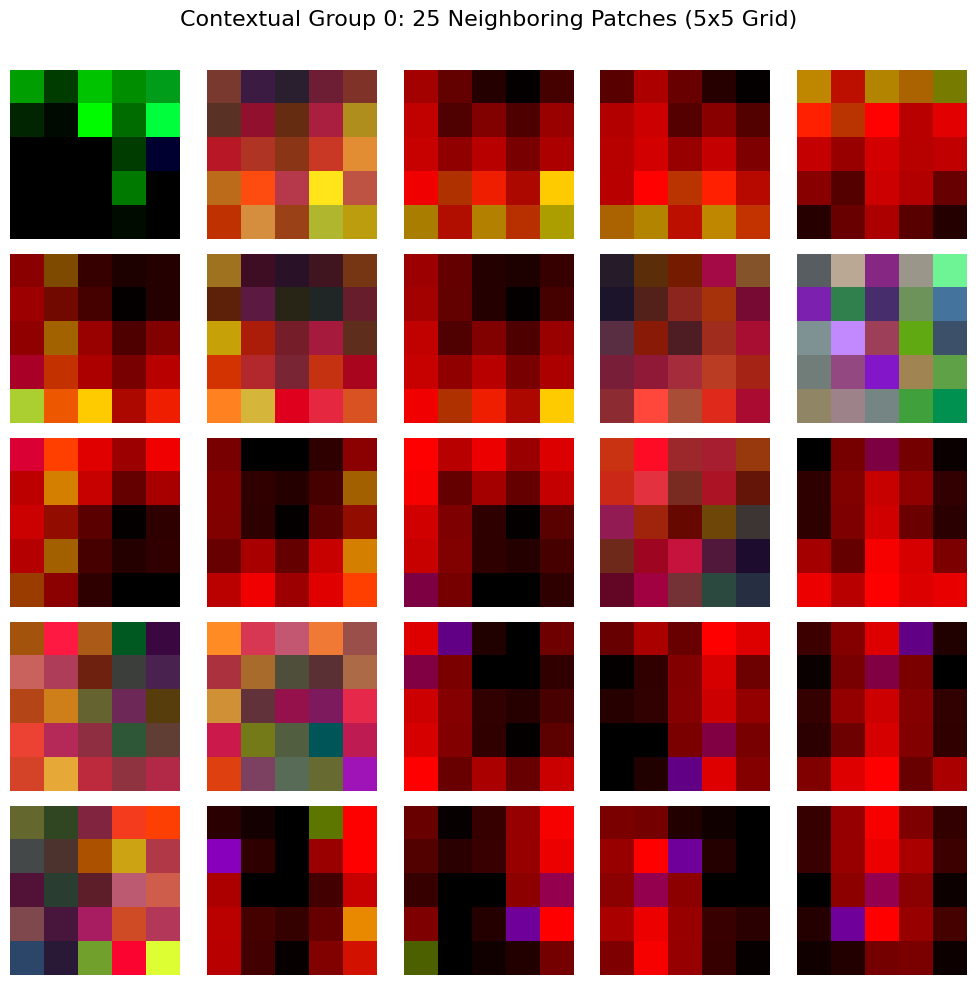

CG-CNN TRAINING (Following Exact Description)
Window size:         5x5
Context radius:      ±2
Images per task:     15
Groups per task:     50
Windows per group:   25
Total tasks:         1500
Refiner output dim:  256 (this is Q')



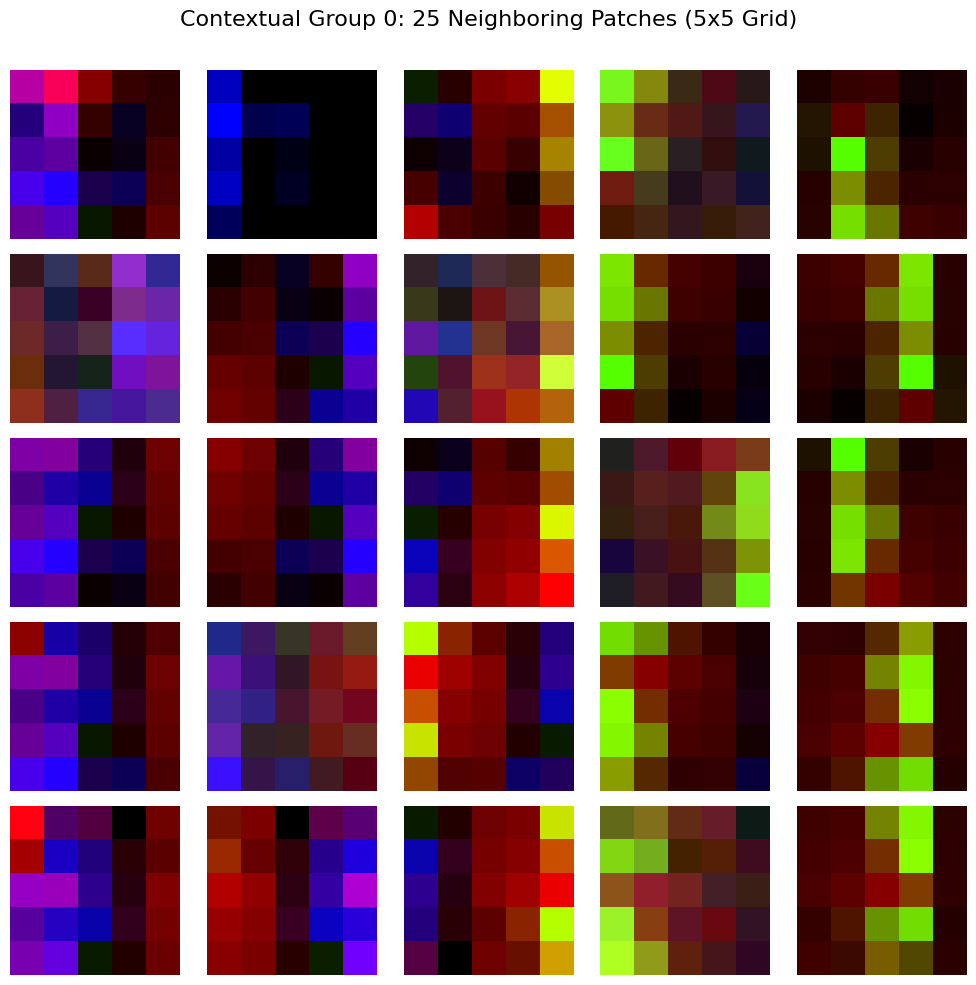

Task  20/1500 | E-Loss: 0.3575 | M-Loss: 0.5661 | Acc: 94.9% | Avg(20): 97.0%
Task  40/1500 | E-Loss: 0.6292 | M-Loss: 0.8420 | Acc: 88.4% | Avg(20): 92.2%


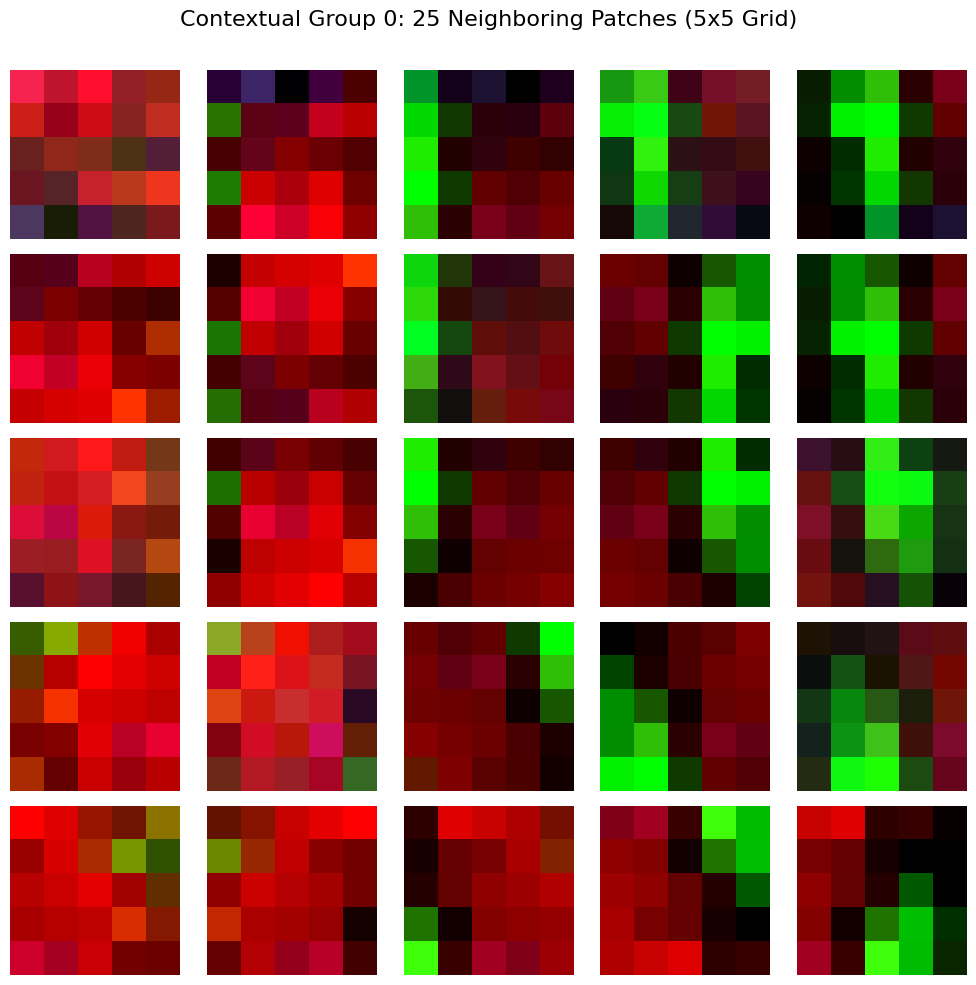

Task  60/1500 | E-Loss: 0.8128 | M-Loss: 0.9609 | Acc: 89.9% | Avg(20): 87.6%
Task  80/1500 | E-Loss: 0.8565 | M-Loss: 0.9649 | Acc: 86.2% | Avg(20): 86.8%
Task 100/1500 | E-Loss: 0.8318 | M-Loss: 0.8948 | Acc: 90.2% | Avg(20): 87.0%


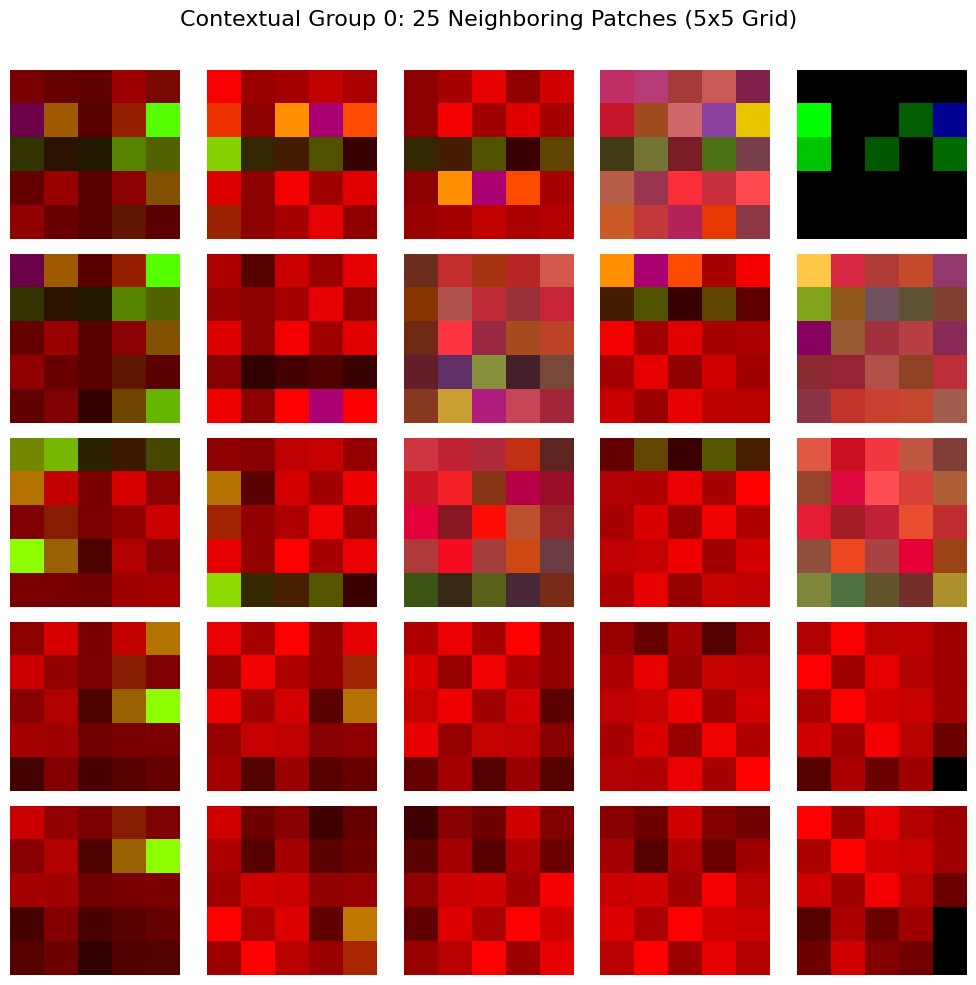

Task 120/1500 | E-Loss: 0.8667 | M-Loss: 0.9175 | Acc: 81.0% | Avg(20): 85.3%
Task 140/1500 | E-Loss: 0.8732 | M-Loss: 0.8993 | Acc: 75.6% | Avg(20): 84.0%


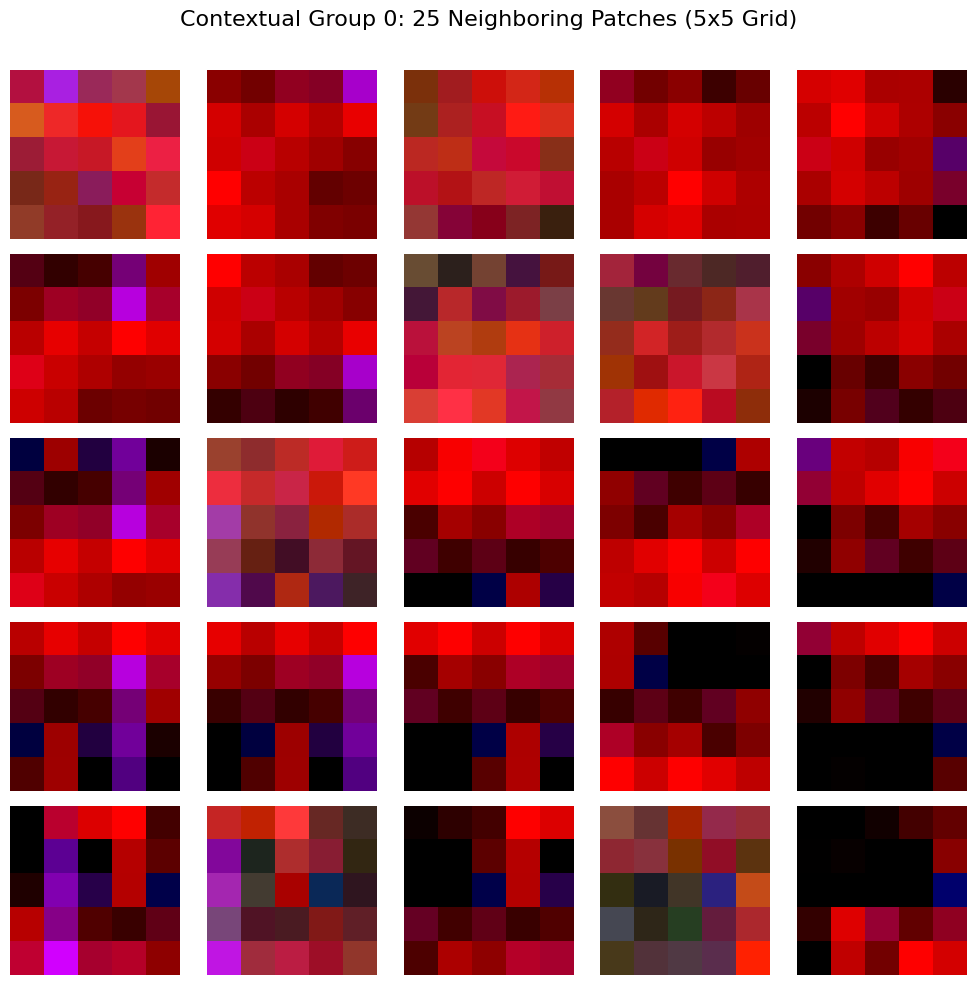

Task 160/1500 | E-Loss: 0.8562 | M-Loss: 0.8801 | Acc: 85.9% | Avg(20): 84.8%
Task 180/1500 | E-Loss: 0.8453 | M-Loss: 0.8694 | Acc: 83.6% | Avg(20): 85.5%
Task 200/1500 | E-Loss: 0.8423 | M-Loss: 0.8586 | Acc: 83.0% | Avg(20): 85.2%


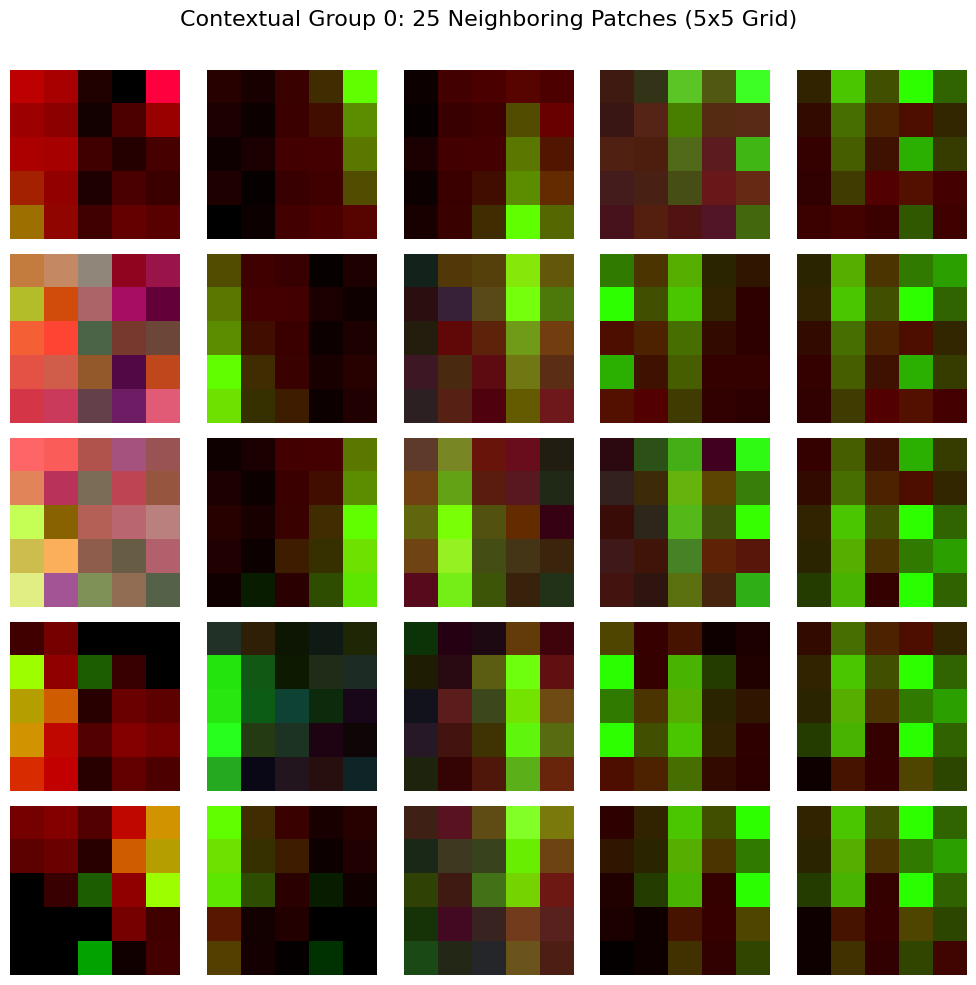

Task 220/1500 | E-Loss: 0.8588 | M-Loss: 0.8626 | Acc: 81.3% | Avg(20): 84.2%
Task 240/1500 | E-Loss: 0.8417 | M-Loss: 0.8559 | Acc: 80.3% | Avg(20): 85.2%


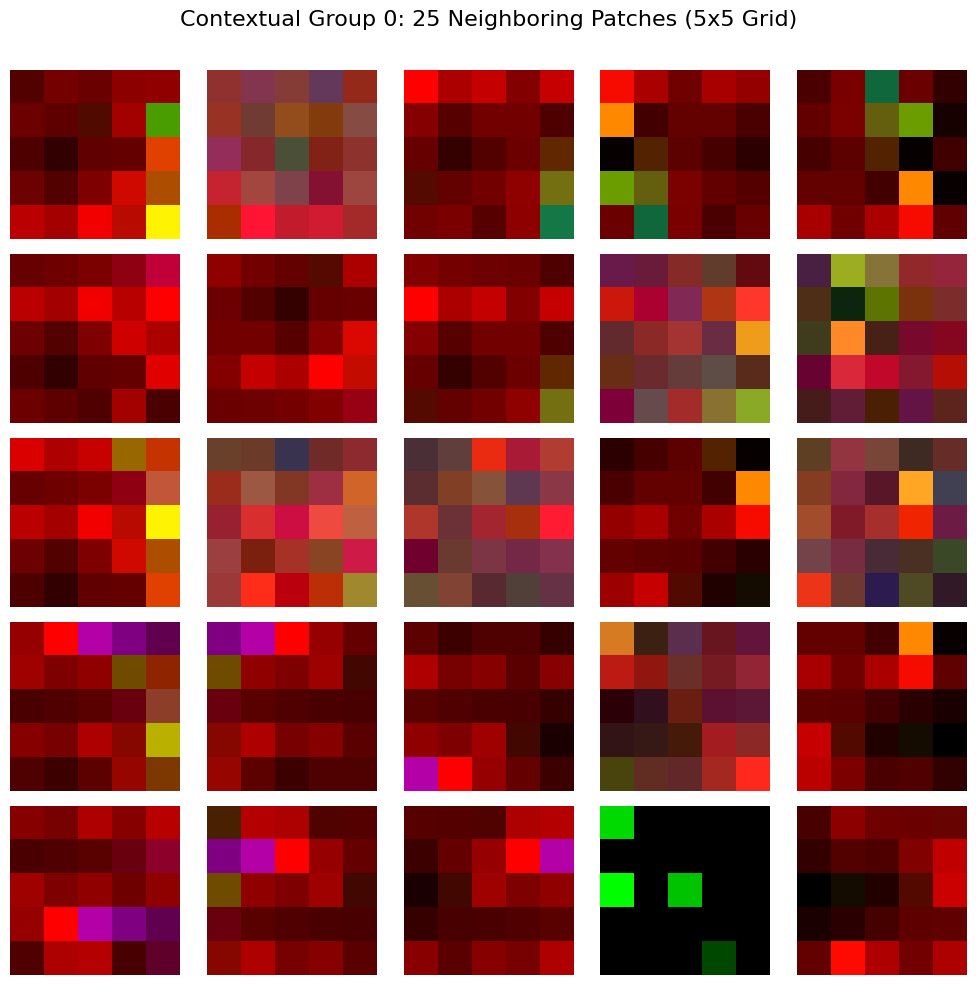

Task 260/1500 | E-Loss: 0.8453 | M-Loss: 0.8551 | Acc: 82.3% | Avg(20): 84.9%
Task 280/1500 | E-Loss: 0.8168 | M-Loss: 0.8194 | Acc: 84.2% | Avg(20): 85.0%
Task 300/1500 | E-Loss: 0.8512 | M-Loss: 0.8613 | Acc: 88.1% | Avg(20): 84.8%


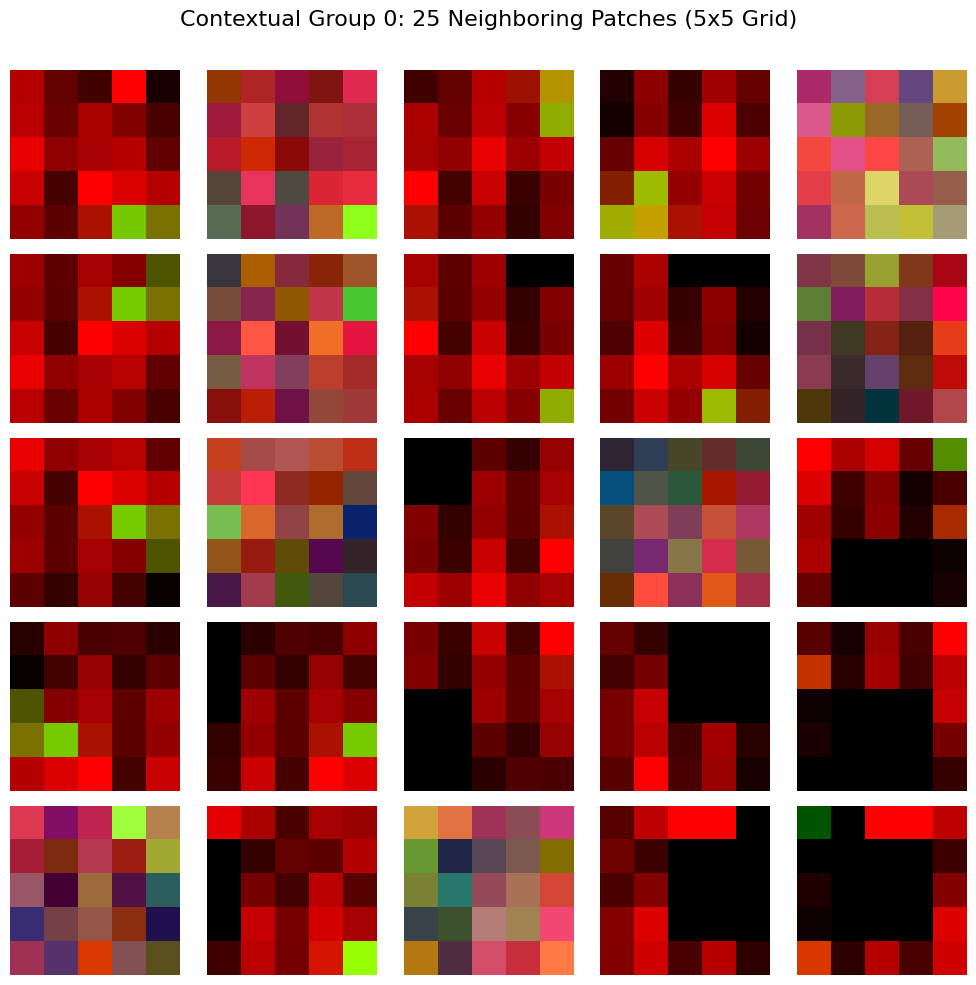

Task 320/1500 | E-Loss: 0.8361 | M-Loss: 0.8337 | Acc: 85.5% | Avg(20): 84.2%
Task 340/1500 | E-Loss: 0.8093 | M-Loss: 0.7975 | Acc: 87.6% | Avg(20): 84.8%


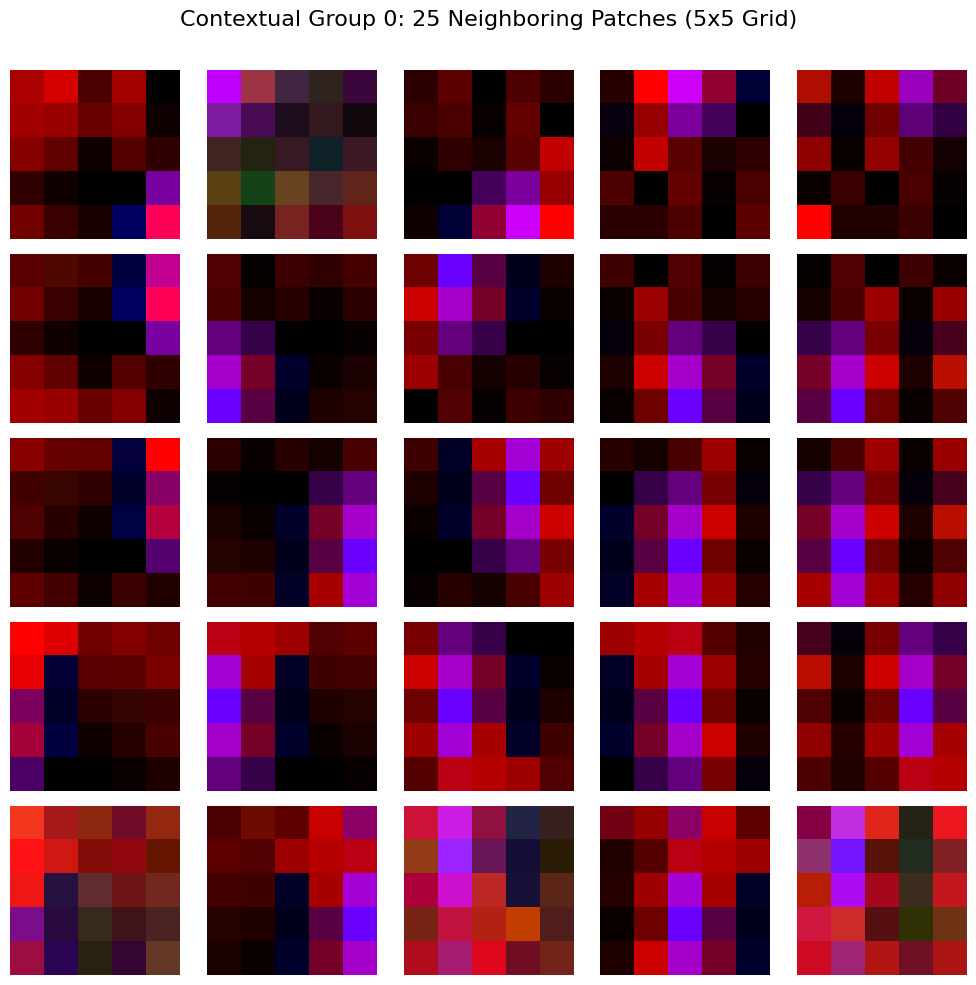

Task 360/1500 | E-Loss: 0.7808 | M-Loss: 0.7643 | Acc: 84.6% | Avg(20): 85.0%
Task 380/1500 | E-Loss: 0.8082 | M-Loss: 0.7994 | Acc: 86.6% | Avg(20): 84.6%
Task 400/1500 | E-Loss: 0.8010 | M-Loss: 0.8036 | Acc: 83.4% | Avg(20): 84.3%


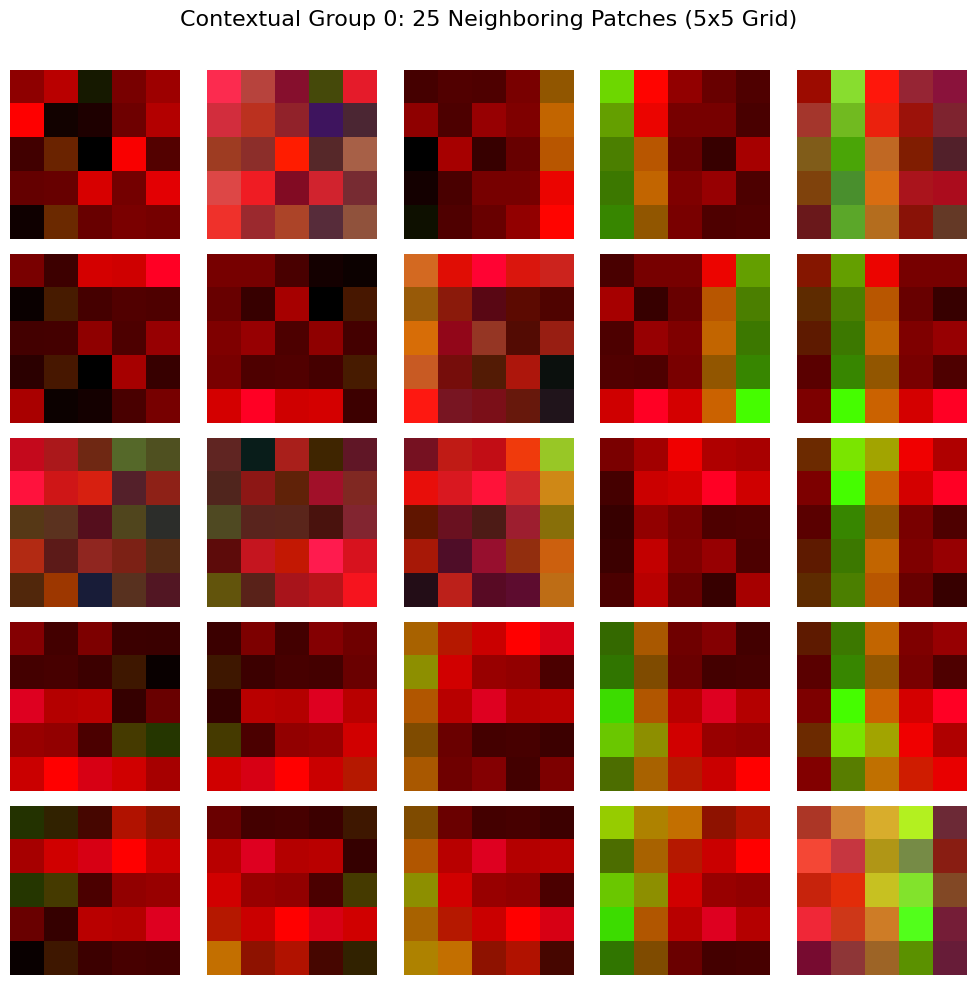

Task 420/1500 | E-Loss: 0.7805 | M-Loss: 0.7599 | Acc: 85.0% | Avg(20): 85.0%
Task 440/1500 | E-Loss: 0.7508 | M-Loss: 0.7415 | Acc: 87.0% | Avg(20): 86.5%


In [ ]:
# ===============================
# 8. MAIN EXECUTION
# ===============================
if __name__ == "__main__":
    print("Loading unlabeled ISIC images...")
    dataset = ISICUnlabeledDataset(IMG_DIR)
    print(f"Loaded {len(dataset)} unlabeled images\n")

    print("Initializing dilated ResNet50...")
    backbone = DilatedResNetBackbone().to(DEVICE)
    print("✅ Backbone ready (extracts P and Q)\n")

    # Initialize trainer
    trainer = CGCNNTrainer(
        backbone=backbone,
        refiner_dim=REFINER_DIM,
        window_size=WINDOW_SIZE,
        g_radius=G_RADIUS,
        n_groups=N_GROUPS,
        device=DEVICE
    )
    # ... (after trainer initialization)
    print("Visualizing a contextual group...")
    visualize_contextual_group(dataset, trainer, group_idx=0)

    # Train CG-CNN to learn Q'
    trainer.train(
        dataset=dataset,
        n_tasks=N_TASKS,
        n_images_per_task=N_IMAGES_PER_TASK,
        em_iterations=20
    )

    # Save Q'
    trainer.save_model(MODEL_SAVE_PATH)

    # Compare Q vs Q' (uncomment when you have labeled data)
    print("\nTo compare Q vs Q', uncomment and set:")
    print("TEST_CSV = '/path/to/test_metadata.csv'")
    print("TEST_IMG_DIR = '/path/to/test/images'")
    print("compare_Q_vs_Qprime(backbone, MODEL_SAVE_PATH, TEST_CSV, TEST_IMG_DIR, DEVICE)")

In [ ]:
# ===============================
# 8. MAIN EXECUTION (EVALUATION MODE)
# ===============================
if __name__ == "__main__":
    # --- UPDATE THESE PATHS ---
    TEST_CSV = "/content/drive/MyDrive/CGCNN_research/test_set/test_metadata.csv"
    TEST_IMG_DIR = "/content/drive/MyDrive/CGCNN_research/test_set/data"
    # --------------------------

    print("Initializing dilated ResNet50...")
    backbone = DilatedResNetBackbone().to(DEVICE)

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"✅ Found trained model at {MODEL_SAVE_PATH}")

        # Run the comparison
        compare_Q_vs_Qprime(
            backbone=backbone,
            refiner_path=MODEL_SAVE_PATH,
            csv_path=TEST_CSV,
            img_dir=TEST_IMG_DIR,
            device=DEVICE
        )
    else:
        print("❌ Trained model not found. Please run training first.")